## Partie I: Preparation des données (preprocessing)

In [1]:
import pandas as pd
import requests
from io import BytesIO #permet de stocker en mémoire
from zipfile import ZipFile

url2019 = "https://www.insee.fr/fr/statistiques/fichier/4809583/fd_eec19_csv.zip" #enquete 2019
url2020="https://www.insee.fr/fr/statistiques/fichier/5393560/fd_eec20_csv.zip" #enquête 2020 en exemple

# Télécharge le fichier ZIP
requete = requests.get(url2019)
zip_df = ZipFile(BytesIO(requete.content)) #créer un fichier ZIP

# Extraire le fichier CSV du ZIP
with zip_df.open(zip_df.namelist()[0]) as extrait:
    EEC_2019 = pd.read_csv(extrait, delimiter=";") # Lire le fichier CSV avec pandas

# Télécharge le fichier ZIP
requete = requests.get(url2020)
zip_df = ZipFile(BytesIO(requete.content)) #créer un fichier ZIP

# Extraire le fichier CSV du ZIP
with zip_df.open(zip_df.namelist()[0]) as extrait:
    EEC_2020 = pd.read_csv(extrait, delimiter=";") # Lire le fichier CSV avec pandas

In [2]:
# On choisit un set de variables qui ne comprend que données sociodémographiques, géographiques associées à l'individu
# et au ménage étudié + qui soit disponible sur les deux années étudiées

# Var d'interet -> ACTEU

# Var explicatives  à inclure dans le modèle -> AGE3 ;  AGE5 ; ANNEE ;TRIM ;  CATAU2010R ; COURED ; CSTOT (pour avoir actifs et inactifs) ;CSTOTR ;
# CSTOTPRM ; DIP11; ENFRED ; METRODOM ; NFRRED ; SEXE ; TYPMEN7 

# USE? -> AIDFAM , CHPUB?? (Employeur de la profession principale?), EXTRIAN? (pondération)

# Meme si les variables sont colinéaires (AGE3, AGE5), on peut les garder et faire en sorte que le predicteur
# choisisse la plus pertinente

list_var_selected = ["ACTEU","ANNEE" ,"TRIM", "AGE3" ,  "AGE5"  , "CATAU2010R" ,
"COURED" ,"CSTOT" ,"CSTOTR" ,"CSTOTPRM" , "DIP11","ENFRED" , "METRODOM" , "NFRRED" , "SEXE" , "TYPMEN7"]

EEC_2019 = EEC_2019[list_var_selected]
EEC_2020 = EEC_2020[list_var_selected]

list_var = list(EEC_2019.columns.values)
print(list_var)

EEC_2019 = EEC_2019[EEC_2019['TRIM'] ==1]
EEC_2020 = EEC_2020[EEC_2020['TRIM'] ==4]

# Il y a très peu de valeurs manquantes dans les variables ->  dropna() drops any row that contains at least one missing value
# On aurait aussi pu faire de l'imputation
print(EEC_2019.shape)
EEC_2019 = EEC_2019.dropna() 
EEC_2020 = EEC_2020.dropna() 
print(EEC_2019.shape)


# Converti l'ensemble des variables catégorielles en dummies -> Réflèxe économétrique mais est ce pertinent ici?
EEC_2019 = pd.get_dummies(EEC_2019, columns=["AGE3" ,  "AGE5"  , "CATAU2010R" ,
"COURED" ,"CSTOT" ,"CSTOTR" ,"CSTOTPRM" , "DIP11","ENFRED" , "METRODOM" , "NFRRED" , "SEXE" , "TYPMEN7"])
EEC_2020 = pd.get_dummies(EEC_2020, columns=["AGE3" ,  "AGE5"  , "CATAU2010R" ,
"COURED" ,"CSTOT" ,"CSTOTR" ,"CSTOTPRM" , "DIP11","ENFRED" , "METRODOM" , "NFRRED" , "SEXE" , "TYPMEN7"])

# 137 variables 
print(EEC_2019.shape)

# Gestion des outliers??? Pas nécessaire ici puisqu'on fonctionne seulement avec des variables catégorielles

EEC_2019_subsample = EEC_2019.sample(n=1000, random_state=3) 


['ACTEU', 'ANNEE', 'TRIM', 'AGE3', 'AGE5', 'CATAU2010R', 'COURED', 'CSTOT', 'CSTOTR', 'CSTOTPRM', 'DIP11', 'ENFRED', 'METRODOM', 'NFRRED', 'SEXE', 'TYPMEN7']
(106400, 16)
(105338, 16)
(105338, 137)


In [3]:
import numpy as np
import matplotlib.pyplot as plt

# On construit un array contentant l'ensemble des variables explicatives (on exclut donc ACTEU/ANNEE/TRIM)
X = np.array(EEC_2019_subsample.drop(columns=["ACTEU","ANNEE", "TRIM"]))

print(X.shape)
# Array contentant la variable expliquée
y = np.array(EEC_2019_subsample["ACTEU"])
# convert "Chomage" in 1 and the other labels (here, "Inactif", "Actif occupé") into 1
y = np.where(y==2, 1, 0)
print(y.shape)

print(X[:10])

(1000, 134)
(1000,)
[[False  True False ... False False False]
 [False False  True ... False False  True]
 [False  True False ... False False False]
 ...
 [ True False False ... False False False]
 [ True False False ... False False False]
 [False  True False ... False False False]]


In [4]:
#from sklearn.preprocessing import StandardScaler
# standardisation des variables explicatives,  c’est-à-dire de centrer et réduire chaque variable
# en la divisant par sa variance  -> pas utile pour mes variables catégorielles transformées en dummies

# std_scale = StandardScaler().fit(X_train)
# X_train_scaled = std_scale.transform(X_train)
# X_test_scaled = std_scale.transform(X_test)

# La standardisation permet une convergence plus rapide des algorithmes pour des variables réelles


## Partie II : Support Vector Machine

In [5]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=.2, random_state=3)

In [6]:
from sklearn.svm import SVC
#SVC est le modèle SVM permettant la classification

acc_train, acc_test = list(), list()

C_range = np.linspace(0.1, 20, 50)
for param in C_range:
    clf = SVC( C=param)
    clf.fit(X_train, y_train)
    acc_train.append(clf.score(X_train, y_train))
    acc_test.append(clf.score(X_test, y_test))

#  ATTENTION -> Peut etre faut-il travailler avec un autre critère de performance que accuracy pour selectionner
#  le meilleur modèle


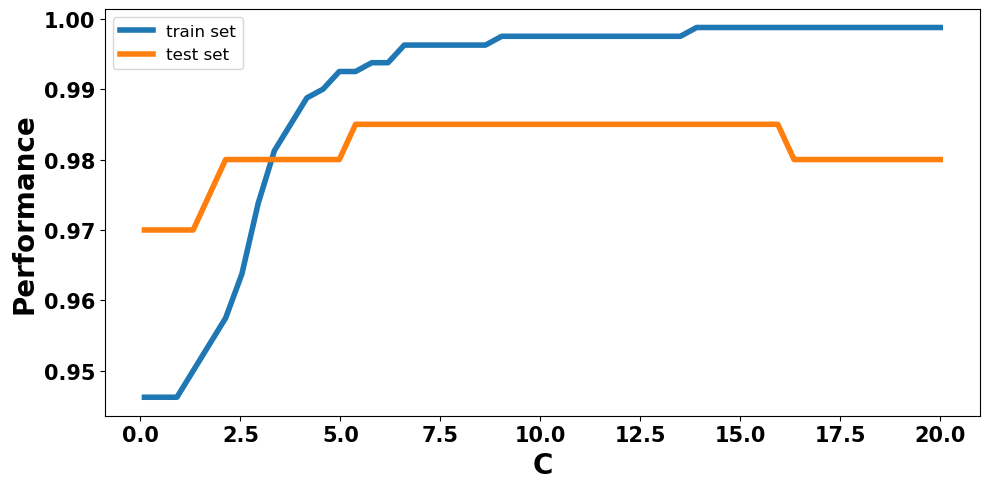

In [7]:
plt.figure(figsize=(10, 5))

plt.plot(C_range, acc_train, label='train set', lw=4)
plt.plot(C_range, acc_test, label='test set', lw=4)

plt.legend(loc='best', fontsize=12)

plt.xlabel("C", fontweight="bold", fontsize=20)
plt.ylabel("Performance", fontweight="bold", fontsize=20)
plt.xticks(fontweight="bold", fontsize=15)
plt.yticks(fontweight="bold", fontsize=15)
plt.tight_layout()

plt.show()

 PB : L'evolution de la performance par rapport à C me parait étrange


## Partie III - Regression logistique

In [30]:
from sklearn.model_selection import GridSearchCV
import warnings
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score


warnings.filterwarnings("ignore", category=FutureWarning)

params= { 'C':[ 0.1,20, 50]}

# Régression logistique avec régularisation Ridge (régularisation L2)
lr =LogisticRegression(penalty='l2', dual=False, tol=0.0001, C=1.0, fit_intercept=True, 
                   intercept_scaling=1, class_weight=None, random_state=3, solver='liblinear',
                   max_iter=100, multi_class='auto', verbose=0, warm_start=False, n_jobs=None,
                   l1_ratio=None)

# Processus de cross-validation qui découpe notre échantillon en 5 et détermine le paramètre de régularisation optimal
gs = GridSearchCV(estimator=lr, 
                   param_grid=params,
                   cv=5)

gs.fit(X_train, y_train)



print(gs.best_params_)
print(gs.score(X_train, y_train))
print(gs.score(X_test, y_test))

# ATTENTION -> Best paramètre est toujours celui avec la régularisation la + forte

{'C': 0.1}
0.94625
0.97


In [28]:
acc_train, acc_test = list(), list()
C_range = np.linspace(0.1, 20, 50)
for param in C_range:
    clf = LogisticRegression(penalty='l1', dual=False, tol=0.0001, C=param, fit_intercept=True, 
                   intercept_scaling=1, class_weight=None, random_state=3, solver='liblinear',
                   max_iter=100, multi_class='auto', verbose=0, warm_start=False, n_jobs=None,
                   l1_ratio=None)
    
    clf.fit(X_train, y_train)
    acc_train.append(clf.score(X_train, y_train))
    acc_test.append(clf.score(X_test, y_test))

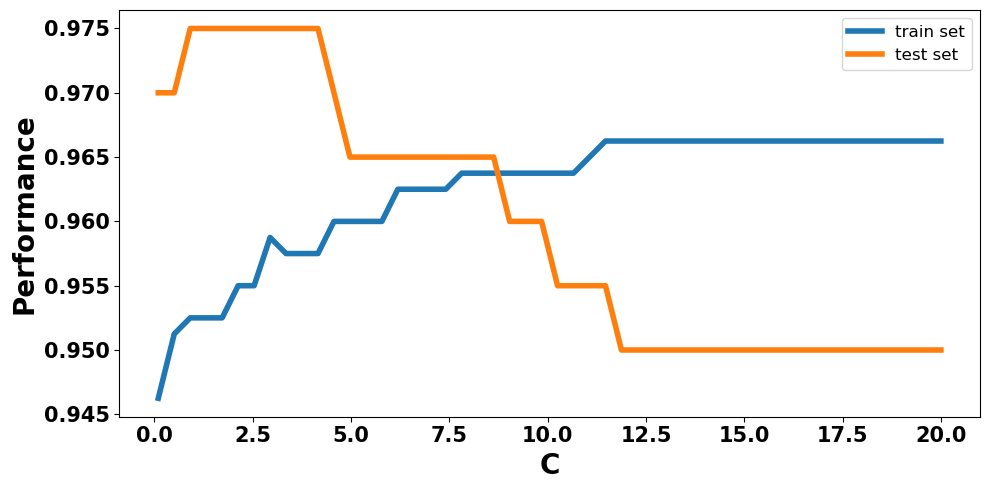

In [29]:
plt.figure(figsize=(10, 5))

plt.plot(C_range, acc_train, label='train set', lw=4)
plt.plot(C_range, acc_test, label='test set', lw=4)

plt.legend(loc='best', fontsize=12)

plt.xlabel("C", fontweight="bold", fontsize=20)
plt.ylabel("Performance", fontweight="bold", fontsize=20)
plt.xticks(fontweight="bold", fontsize=15)
plt.yticks(fontweight="bold", fontsize=15)
plt.tight_layout()

plt.show()


## Partie IV : Selections de variables

In [11]:
print(X[:100]) 

[[False  True False ... False False False]
 [False False  True ... False False  True]
 [False  True False ... False False False]
 ...
 [False False  True ... False False False]
 [False False  True ... False False False]
 [False False  True ... False False False]]


In [24]:
from sklearn.linear_model import LassoCV
from sklearn.feature_selection import SelectFromModel

clf = LassoCV()

# Je m'impose un maximum XX features
sfm = SelectFromModel(clf, threshold=None, prefit=False, norm_order=1, max_features=20)

sfm.fit(X,y)
X_transform = sfm.transform(X)
print(X_transform.shape)

(1000, 20)


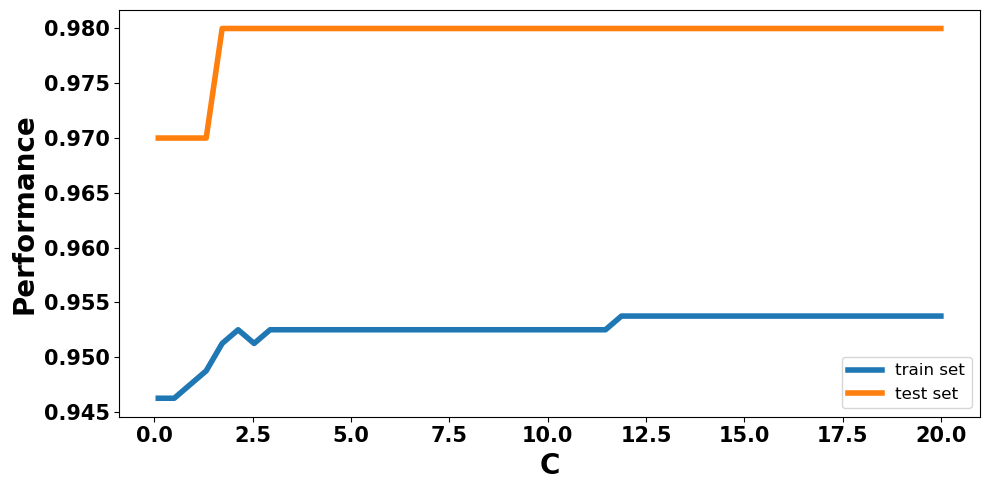

In [25]:
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_transform, 
                                                    y, 
                                                    test_size=.2, random_state=3)

from sklearn.linear_model import LogisticRegression

acc_train, acc_test = list(), list()
C_range = np.linspace(0.1, 20, 50)
for param in C_range:
    clf = LogisticRegression(penalty='l2', dual=False, tol=0.001, C=param, fit_intercept=True, 
                   intercept_scaling=1, class_weight=None, random_state=3, solver='liblinear',
                   max_iter=100, multi_class='auto', verbose=0, warm_start=False, n_jobs=None,
                   l1_ratio=None)
    
    clf.fit(X_train_2, y_train_2)
    acc_train.append(clf.score(X_train_2, y_train_2))
    acc_test.append(clf.score(X_test_2, y_test_2))
    
plt.figure(figsize=(10, 5))

plt.plot(C_range, acc_train, label='train set', lw=4)
plt.plot(C_range, acc_test, label='test set', lw=4)

plt.legend(loc='best', fontsize=12)

plt.xlabel("C", fontweight="bold", fontsize=20)
plt.ylabel("Performance", fontweight="bold", fontsize=20)
plt.xticks(fontweight="bold", fontsize=15)
plt.yticks(fontweight="bold", fontsize=15)
plt.tight_layout()

plt.show()


In [27]:

# Cherche la meilleure combinaison de paramètres à partir d'une grille: 
# 50 valeurs de regularisation
# Regularisation Lasso ou Ridge
# 3 valeurs de tolérance pour les critères d'arrêt
# (Le processus d'optimisation s'arrête lorsque la modification des coefficients est inférieure à la tolérance spécifiée)
params= { 'C':[0.1, 20, 50], 'penalty': ['l1','l2'],'tol': [10, 1, 0.01,0.1] }


lr =LogisticRegression( dual=False, fit_intercept=True, 
                   intercept_scaling=1, class_weight=None, random_state=3, solver='liblinear',
                   max_iter=100, multi_class='auto', verbose=0, warm_start=False, n_jobs=None,
                   l1_ratio=None)

gs = GridSearchCV(estimator=lr, 
                   param_grid=params,
                   cv=5)

gs.fit(X_train_2, y_train_2)

print(gs.best_params_)
print(gs.score(X_train_2, y_train_2))
print(gs.score(X_test_2, y_test_2))


# ATTENTION -> Best paramètre est toujours celui avec la régularisation la - forte
# Resultat en contradiction avec les précédents 


{'C': 20, 'penalty': 'l1', 'tol': 1}
0.95375
0.98
